In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import Descriptors, rdFMCS, Draw
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import pandas as pd
from rdkit import DataStructs

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
def load_data(random_state = 42):
    # Load the dataset
    ldtoxdb = pd.read_csv('../../data/full_dataset.csv')

    # Filter the dataset based on 'pfas_like'
    df_true = ldtoxdb[ldtoxdb['is_pfas_like'] == True]
    df_false = ldtoxdb[ldtoxdb['is_pfas_like'] == False]
        
    train_true, test_true = train_test_split(df_true, test_size=0.1, random_state=random_state, stratify=df_true['epa'])
    train_false, test_false = train_test_split(df_false, test_size=0.2, random_state=random_state, stratify=df_false['epa'])  # 80%-20% split
    
    # Combine the splits
    train_data = pd.concat([train_true, train_false], axis=0)
    test_data = pd.concat([test_true, test_false], axis=0)
   
    # Return the final split data
    return train_data, test_data

train, test = load_data()

In [4]:
miss_rf_gp = pd.read_csv('misclassified_rf_gp.csv')
miss_gcn = pd.read_csv('misclassified_gcn.csv')

smiles1 = set(miss_rf_gp['smiles'])
smiles2 = set(miss_gcn['smiles'])

# Find the intersection of the two sets
miss_smiles = list(smiles1.intersection(smiles2))

In [5]:
outliers_rf_gp = pd.read_csv("outliers_rf_gp.csv")
outliers_gcn = pd.read_csv("outliers_rf_gp.csv")

smiles1 = set(outliers_rf_gp['smiles'])
smiles2 = set(outliers_gcn['smiles'])

# Find the intersection of the two sets
outliers_smiles = list(smiles1.intersection(smiles2))

In [6]:
# Split the `test` dataset based on the outliers list
outliers_in_test = test[test['smiles'].isin(outliers_smiles)]
non_outliers_in_test = test[~test['smiles'].isin(outliers_smiles)]

# Split the `test` dataset based on the misclassified list
misclassified_in_test = test[test['smiles'].isin(miss_smiles)]
non_misclassified_in_test = test[~test['smiles'].isin(miss_smiles)]

### Outliers

In [7]:
# Morgan fingerprint generator
morgan_generator = GetMorganGenerator(radius=2)

def get_valid_fingerprints(smiles_list):
    fingerprints = []
    valid_smiles = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fingerprints.append(morgan_generator.GetFingerprint(mol))  # Use GetFingerprint, not GetCountFingerprint
            valid_smiles.append(smiles)
    return fingerprints, valid_smiles

# Check datasets exist and are valid
for dataset in [train, outliers_in_test, non_outliers_in_test]:
    if not isinstance(dataset, pd.DataFrame) or 'smi' not in dataset.columns:
        raise ValueError("Dataset is invalid or missing 'smi' column.")

# Generate fingerprints for each dataset
fps_training, valid_train_smiles = get_valid_fingerprints(train['smi'])
fps_outliers, valid_outliers = get_valid_fingerprints(outliers_in_test['smi'])
fps_non_outliers, valid_non_outliers = get_valid_fingerprints(non_outliers_in_test['smi'])

# Ensure no dataset is empty
if not fps_training or not fps_outliers or not fps_non_outliers:
    raise ValueError("One of the datasets resulted in empty fingerprints.")

# Calculate Tanimoto similarity
results_sim_outliers = []
results_sim_non_outliers = []

# Compare Outliers against Training
for i, fp_training in enumerate(fps_training):
    for j, fp_outlier in enumerate(fps_outliers):
        similarity = DataStructs.TanimotoSimilarity(fp_training, fp_outlier)
        results_sim_outliers.append({'training_smi': valid_train_smiles[i], 'outlier_smi': valid_outliers[j], 'similarity': similarity})

# Compare Non-Outliers against Training
for i, fp_training in enumerate(fps_training):
    for j, fp_non_outlier in enumerate(fps_non_outliers):
        similarity = DataStructs.TanimotoSimilarity(fp_training, fp_non_outlier)
        results_sim_non_outliers.append({'training_smi': valid_train_smiles[i], 'non_outlier_smi': valid_non_outliers[j], 'similarity': similarity})

# Convert results to DataFrames
similarity_outliers = pd.DataFrame(results_sim_outliers)
similarity_non_outliers = pd.DataFrame(results_sim_non_outliers)

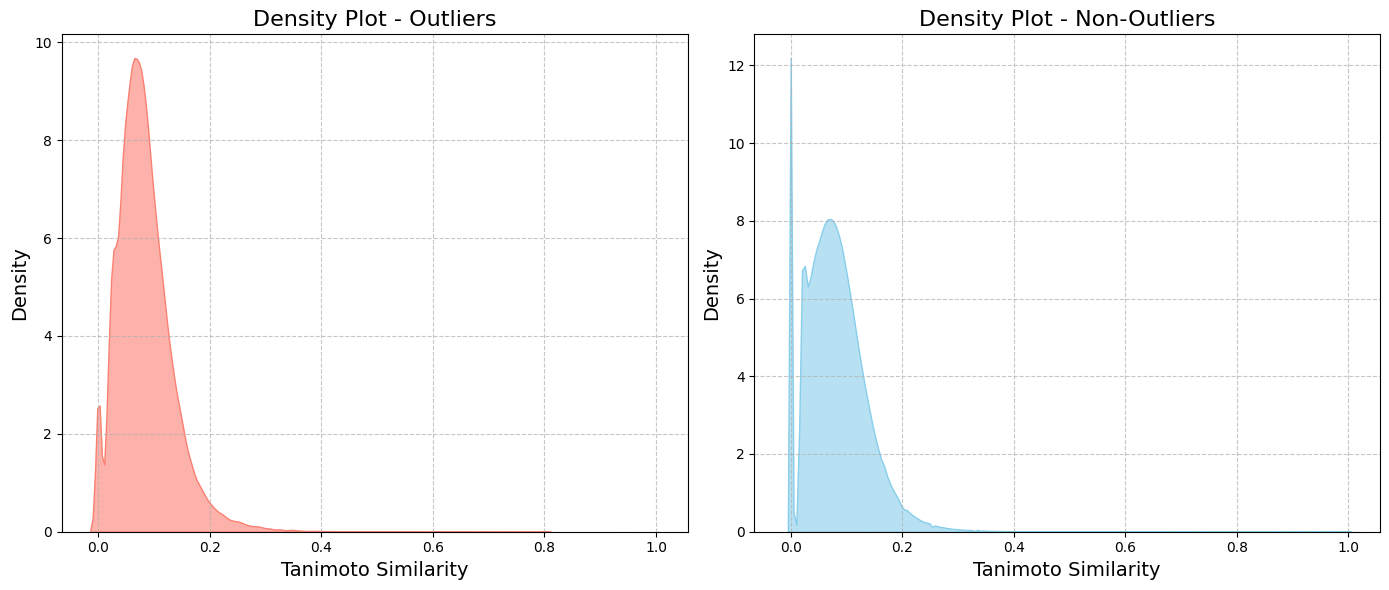

In [8]:
# Separate data for outliers and non-outliers
similarity_outliers['type'] = 'Outliers'
similarity_non_outliers['type'] = 'Non-Outliers'

# Plot side-by-side density plots with separate Y axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)  # Share X axis but not Y axis

# Outliers Plot
sns.kdeplot(data=similarity_outliers, x='similarity', fill=True, ax=axes[0], color='salmon', alpha=0.6)
axes[0].set_title('Density Plot - Outliers', fontsize=16)
axes[0].set_xlabel('Tanimoto Similarity', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Non-Outliers Plot
sns.kdeplot(data=similarity_non_outliers, x='similarity', fill=True, ax=axes[1], color='skyblue', alpha=0.6)
axes[1].set_title('Density Plot - Non-Outliers', fontsize=16)
axes[1].set_xlabel('Tanimoto Similarity', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

### Misclassified

In [ ]:
# Check datasets exist and are valid
for dataset in [train, misclassified_in_test, non_misclassified_in_test]:
    if not isinstance(dataset, pd.DataFrame) or 'smiles' not in dataset.columns:
        raise ValueError("Dataset is invalid or missing 'smiles' column.")

# Generate fingerprints for each dataset
fps_training, valid_train_smiles = get_valid_fingerprints(train['smiles'])
fps_misclassified, valid_misclassified_smiles = get_valid_fingerprints(misclassified_in_test['smiles'])
fps_non_misclassified, valid_non_misclassified_smiles = get_valid_fingerprints(non_misclassified_in_test['smiles'])

# Ensure no dataset is empty
if not fps_training or not fps_misclassified or not fps_non_misclassified:
    raise ValueError("One of the datasets resulted in empty fingerprints.")

# Calculate Tanimoto similarity
results_sim_misclassified = []
results_sim_non_misclassified = []

# Compare Misclassified against Training
for i, fp_training in enumerate(fps_training):
    for j, fp_misclassified in enumerate(fps_misclassified):
        similarity = DataStructs.TanimotoSimilarity(fp_training, fp_misclassified)
        results_sim_misclassified.append({
            'training_smi': valid_train_smiles[i],
            'misclassified_smi': valid_misclassified_smiles[j],
            'similarity': similarity
        })

# Compare Non-Misclassified against Training
for i, fp_training in enumerate(fps_training):
    for j, fp_non_misclassified in enumerate(fps_non_misclassified):
        similarity = DataStructs.TanimotoSimilarity(fp_training, fp_non_misclassified)
        results_sim_non_misclassified.append({
            'training_smi': valid_train_smiles[i],
            'non_misclassified_smi': valid_non_misclassified_smiles[j],
            'similarity': similarity
        })

# Convert results to DataFrames
similarity_misclassified = pd.DataFrame(results_sim_misclassified)
similarity_non_misclassified = pd.DataFrame(results_sim_non_misclassified)

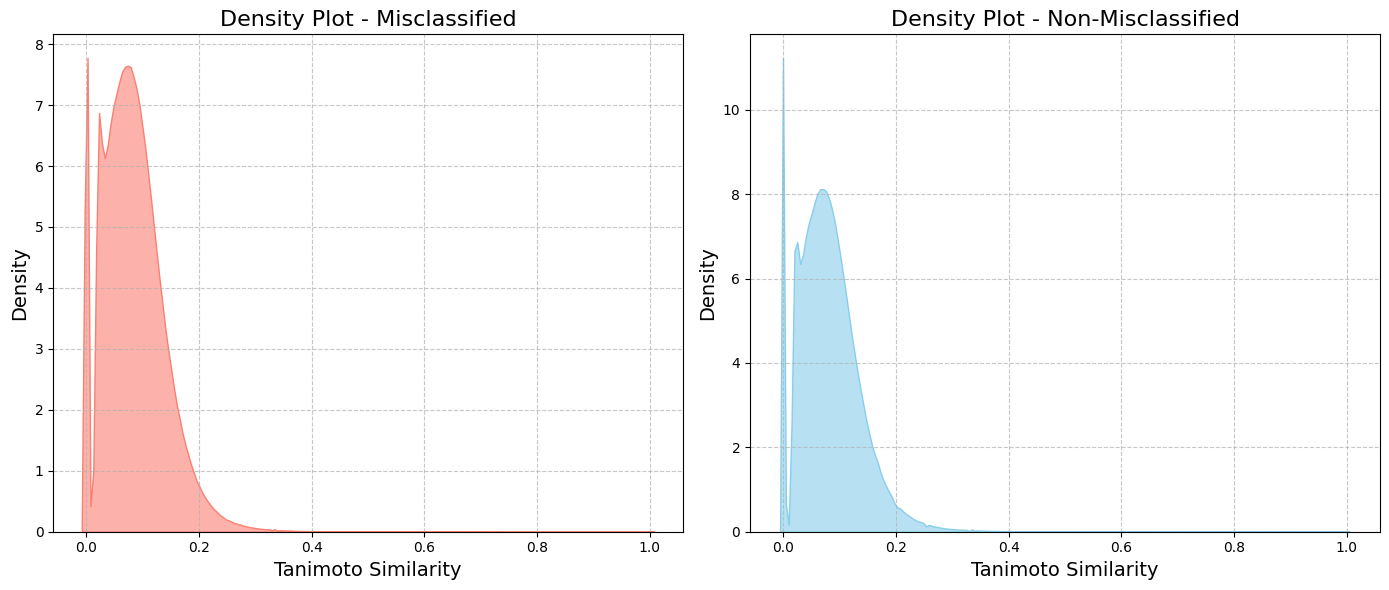

In [11]:
similarity_misclassified['type'] = 'Misclassified'
similarity_non_misclassified['type'] = 'Non-Misclassified'

# Plot side-by-side density plots with separate Y axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)  # Share X axis but separate Y axes

# Misclassified Plot
sns.kdeplot(data=similarity_misclassified, x='similarity', fill=True, ax=axes[0], color='salmon', alpha=0.6)
axes[0].set_title('Density Plot - Misclassified', fontsize=16)
axes[0].set_xlabel('Tanimoto Similarity', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Non-Misclassified Plot
sns.kdeplot(data=similarity_non_misclassified, x='similarity', fill=True, ax=axes[1], color='skyblue', alpha=0.6)
axes[1].set_title('Density Plot - Non-Misclassified', fontsize=16)
axes[1].set_xlabel('Tanimoto Similarity', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

### PFAS

In [18]:
# Get all PFAS-like samples from the test set
pfas_like_test = test[test['is_pfas_like'] == True]

# Get misclassified samples from the test set
misclassified_in_test = test[test['smiles'].isin(miss_smiles)]

# PFAS-like samples that are misclassified
pfas_misclassified = pfas_like_test[pfas_like_test['smiles'].isin(miss_smiles)]

# PFAS-like samples that are NOT misclassified
other_pfas = pfas_like_test[~pfas_like_test['smiles'].isin(miss_smiles)]

In [19]:
fps_pfas_misclassified, valid_pfas_misclassified_smiles = get_valid_fingerprints(is_pfas_misclassified['smiles'])
fps_other_pfas, valid_other_pfas_smiles = get_valid_fingerprints(other_pfas['smiles'])

# Ensure no dataset is empty
if not fps_training or not fps_pfas_misclassified or not fps_other_pfas:
    raise ValueError("One of the datasets resulted in empty fingerprints.")

# Calculate Tanimoto similarity
results_sim_pfas_misclassified = []
results_sim_other_pfas = []

# Compare PFAS Misclassified against Training
for i, fp_training in enumerate(fps_training):
    for j, fp_pfas_misclassified in enumerate(fps_pfas_misclassified):
        similarity = DataStructs.TanimotoSimilarity(fp_training, fp_pfas_misclassified)
        results_sim_pfas_misclassified.append({
            'training_smi': valid_train_smiles[i],
            'pfas_misclassified_smi': valid_pfas_misclassified_smiles[j],
            'similarity': similarity
        })

# Compare Other PFAS against Training
for i, fp_training in enumerate(fps_training):
    for j, fp_other_pfas in enumerate(fps_other_pfas):
        similarity = DataStructs.TanimotoSimilarity(fp_training, fp_other_pfas)
        results_sim_other_pfas.append({
            'training_smi': valid_train_smiles[i],
            'other_pfas_smi': valid_other_pfas_smiles[j],
            'similarity': similarity
        })

# Convert results to DataFrames
similarity_pfas_misclassified = pd.DataFrame(results_sim_pfas_misclassified)
similarity_other_pfas = pd.DataFrame(results_sim_other_pfas)

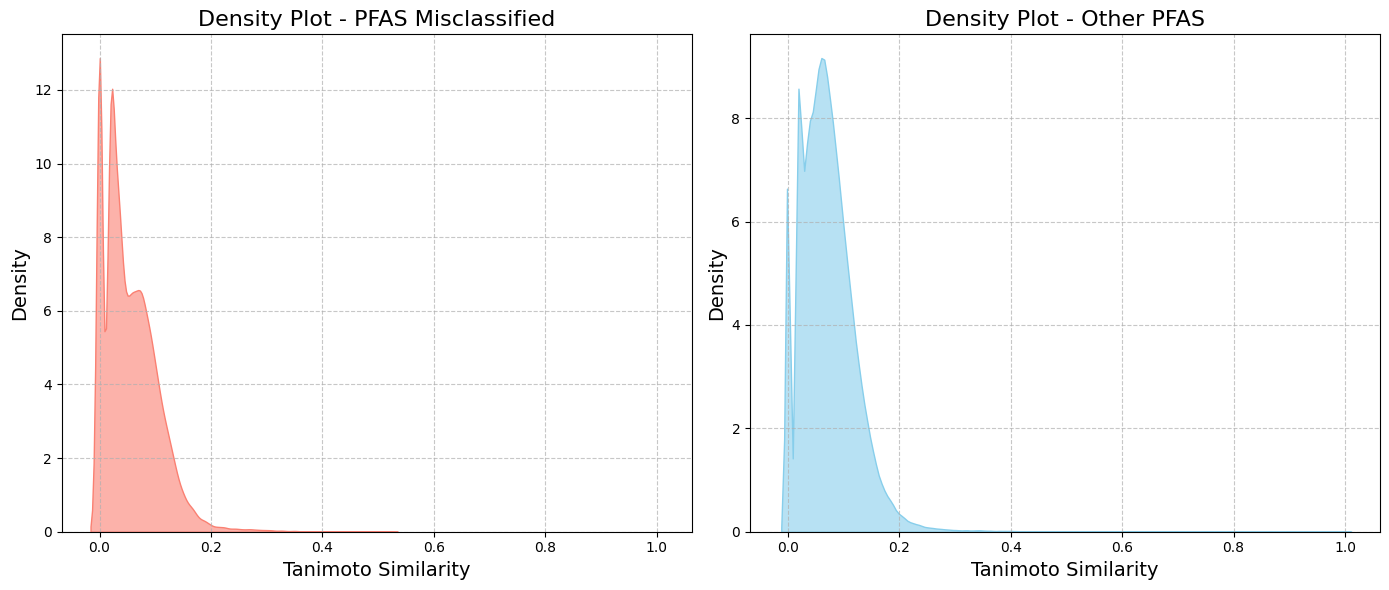

In [20]:
# Add a 'type' column for labeling
similarity_pfas_misclassified['type'] = 'PFAS Misclassified'
similarity_other_pfas['type'] = 'Other PFAS'

# Plot side-by-side density plots with separate Y axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)  # Share X axis but separate Y axes

# PFAS Misclassified Plot
sns.kdeplot(data=similarity_pfas_misclassified, x='similarity', fill=True, ax=axes[0], color='salmon', alpha=0.6)
axes[0].set_title('Density Plot - PFAS Misclassified', fontsize=16)
axes[0].set_xlabel('Tanimoto Similarity', fontsize=14)
axes[0].set_ylabel('Density', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)

# Other PFAS Plot
sns.kdeplot(data=similarity_other_pfas, x='similarity', fill=True, ax=axes[1], color='skyblue', alpha=0.6)
axes[1].set_title('Density Plot - Other PFAS', fontsize=16)
axes[1].set_xlabel('Tanimoto Similarity', fontsize=14)
axes[1].set_ylabel('Density', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In [12]:
# Read in the dataset
ldtoxdb = pd.read_csv("../../data/full_dataset.csv")
all_smiles_list = ldtoxdb['smi']

# Generate RDKit molecules
all_molecules = [Chem.MolFromSmiles(smile) for smile in valid_outliers]

# Check if any molecules are invalid (None) and filter them out
valid_molecules = [mol for mol in all_molecules if mol is not None]

    
# Check if there are still molecules left to process
if len(valid_molecules) == 0:
    print("No valid molecules available for MCS search.")
else:
    # Find the Maximum Common Substructure (MCS) for valid molecules
    mcs_result_all = rdFMCS.FindMCS(
        valid_molecules,
        matchValences=True,  # Uncommented for potentially better results
        ringMatchesRingOnly=True  # Uncommented for potentially better results
    )
    
    if mcs_result_all:
        mcs_smarts_all = mcs_result_all.smartsString
        print(f"Maximum Common Substructure (SMARTS): {mcs_smarts_all}")
    else:
        print("No Maximum Common Substructure (MCS) found for the provided molecules.")


Maximum Common Substructure (SMARTS): 


In [13]:
# Find the Maximum Common Substructure (MCS) for outliers
mcs_result = rdFMCS.FindMCS(
    valid_molecules, 
    matchValences=True, 
    ringMatchesRingOnly=True
)
mcs_smarts = mcs_result.smartsString
common_substructure = Chem.MolFromSmarts(mcs_smarts)
print(f"Maximum Common Substructure (SMARTS): {mcs_smarts}")

Maximum Common Substructure (SMARTS): 


In [14]:
# 2. Analyze Physicochemical Properties
properties = []
for mol in valid_outliers:
    mw = Descriptors.MolWt(mol)         # Molecular Weight
    logp = Descriptors.MolLogP(mol)    # LogP
    hba = Descriptors.NumHAcceptors(mol) # H-bond acceptors
    hbd = Descriptors.NumHDonors(mol)   # H-bond donors
    properties.append((mw, logp, hba, hbd))



ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors._CalcMolWt(str)
did not match C++ signature:
    _CalcMolWt(class RDKit::ROMol mol, bool onlyHeavy=False)